<a href="https://colab.research.google.com/github/vikram-available/Trading-algo/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/gp_forex/EURUSD1__1.0.csv', delimiter='\t')
data.head()


,2024-05-14 11:21,1.07983,1.07983.1,1.07975,1.07980,42
0,2024-05-14 11:22,1.07981,1.07981,1.07980,1.07980,6
1,2024-05-14 11:23,1.07981,1.07981,1.07969,1.07970,36
2,2024-05-14 11:24,1.07969,1.07972,1.07965,1.07972,45
3,2024-05-14 11:25,1.07973,1.07980,1.07973,1.07979,27
4,2024-05-14 11:26,1.07977,1.07980,1.07976,1.07977,40


In [4]:
df=  pd.read_csv('/content/drive/MyDrive/gp_forex/EURUSD1__1.0.csv', delimiter='\t', header=None)
df.columns= ['Datetime', 'open', 'high', 'low', 'close', 'volume']
df.set_index('Datetime', inplace=True)
#df=df.iloc[-80000:]
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M')

df.head()



,open,high,low,close,volume
Datetime,,,,,
2024-05-14 11:21:00,1.07983,1.07983,1.07975,1.07980,42
2024-05-14 11:22:00,1.07981,1.07981,1.07980,1.07980,6
2024-05-14 11:23:00,1.07981,1.07981,1.07969,1.07970,36
2024-05-14 11:24:00,1.07969,1.07972,1.07965,1.07972,45
2024-05-14 11:25:00,1.07973,1.07980,1.07973,1.07979,27


In [5]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1RuAHJCQlCmBz9c5X0YmJmr_7Ro-lkKyg2MZjgyvt9BI#gid=0


/usr/local/lib/python3.10/dist-packages/google/colab/sheets.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return frame.applymap(_clean_val).replace({np.nan: None})


In [6]:
df.tail()

,open,high,low,close,volume
Datetime,,,,,
2024-08-20 10:55:00,1.10808,1.10813,1.10806,1.10806,54
2024-08-20 10:56:00,1.10808,1.10808,1.10801,1.10801,238
2024-08-20 10:57:00,1.10801,1.10804,1.10798,1.10801,227
2024-08-20 10:58:00,1.10800,1.10824,1.10798,1.10822,508
2024-08-20 10:59:00,1.10823,1.10827,1.10814,1.10819,353


In [7]:
!pip install mplfinance
import mplfinance as mpf



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.5 MB/s eta 0:00:00


In [8]:
pip install pandas_ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=025675449707b16a3066e5f27f8ed9319d5639d8c91a8a1d660c84029e87576a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [9]:
import pandas_ta as ta

df['SMA_20'] = ta.sma(df['close'], length=20)  # Simple Moving Average
df['RSI'] = ta.rsi(df['close'], length=14)  # Relative Strength Index
df['MACD'] = ta.macd(df['close'], fast=12, slow=26, signal=9)['MACD_12_26_9']  # MACD Line
df['MACD_Signal'] = ta.macd(df['close'], fast=12, slow=26, signal=9)['MACDs_12_26_9']  # MACD Signal Line
df['Bollinger_Upper'] = ta.bbands(df['close'], length=20)['BBU_20_2.0']  # Bollinger Bands Upper Band
df['Bollinger_Lower'] = ta.bbands(df['close'], length=20)['BBL_20_2.0']

In [10]:
df.dropna(inplace=True)
df

,open,high,low,close,volume,SMA_20,RSI,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Lower
Datetime,,,,,,,,,,,
2024-05-14 11:54:00,1.07947,1.07948,1.07939,1.07942,72,1.079671,25.296101,-0.000082,-0.000045,1.079940,1.079402
2024-05-14 11:55:00,1.07943,1.07951,1.07941,1.07949,43,1.079653,34.872673,-0.000082,-0.000052,1.079920,1.079386
2024-05-14 11:56:00,1.07951,1.07955,1.07951,1.07953,94,1.079638,39.634791,-0.000078,-0.000057,1.079899,1.079378
2024-05-14 11:57:00,1.07952,1.07954,1.07938,1.07938,88,1.079622,30.599098,-0.000086,-0.000063,1.079903,1.079341
2024-05-14 11:58:00,1.07938,1.07938,1.07927,1.07932,150,1.079601,27.862852,-0.000096,-0.000070,1.079905,1.079297
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-20 10:55:00,1.10808,1.10813,1.10806,1.10806,54,1.107935,57.777393,0.000068,0.000062,1.108219,1.107652
2024-08-20 10:56:00,1.10808,1.10808,1.10801,1.10801,238,1.107946,54.091996,0.000062,0.000062,1.108224,1.107668
2024-08-20 10:57:00,1.10801,1.10804,1.10798,1.10801,227,1.107959,54.091996,0.000057,0.000061,1.108223,1.107695


In [12]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


features = ['close', 'SMA_20', 'RSI', 'MACD_Signal']
data = df[features]

# 5. Scale all features
# Instantiate scalers
feature_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on all features
scaled_features = feature_scaler.fit_transform(data)

# Create a DataFrame with scaled features
data_scaled = pd.DataFrame(scaled_features, columns=features, index=data.index)

close_prices = data['close'].values.reshape(-1, 1)
close_scaler.fit(close_prices)

sequence_length = 60  # Number of time steps to look back

X = []
y = []

for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled.iloc[i - sequence_length:i].values)
    y.append(data_scaled.iloc[i]['close'])  # Target is the scaled 'close' price at time i

X = np.array(X)
y = np.array(y)

# 7. Time-based data splitting
# Use time-based split to prevent data leakage
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# 8. Build the LSTM model
model = Sequential()
model.add(LSTM(units=72, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))



# 9. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 10. Train the LSTM model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 2/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 1.2970e-04 - val_loss: 0.0033
Epoch 3/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 8.3115e-05 - val_loss: 0.0028
Epoch 4/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 6.4025e-05 - val_loss: 0.0047
Epoch 5/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 5.1618e-05 - val_loss: 0.0060
Epoch 6/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 4.6077e-05 - val_loss: 0.0056
Epoch 7/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 4.0753e-05 - val_loss: 0.0059
Epoch 8/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3.8711e-05 - val_loss: 0.0056
Epoch 9/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3.3400e-05 - val_loss: 0.0053
Epoch 10/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 3.2596e-05 - val_loss: 0.0057
Epoch 11/50
2498/2498 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 3.0985e-0

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Now you can use mean_squared_error and mean_absolute_error
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
train_mae = mean_absolute_error(y_train_inv, train_predict)

val_rmse = np.sqrt(mean_squared_error(y_val_inv, val_predict))
val_mae = mean_absolute_error(y_val_inv, val_predict)

test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
test_mae = mean_absolute_error(y_test_inv, test_predict)

print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}')
print(f'Validation RMSE: {val_rmse}, Validation MAE: {val_mae}')
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}')


Train RMSE: 0.0017289435657859313, Train MAE: 0.0014793703437817108
Validation RMSE: 0.003079156865028896, Validation MAE: 0.00278756116875848
Test RMSE: 0.008630815213408373, Test MAE: 0.007737738041954102


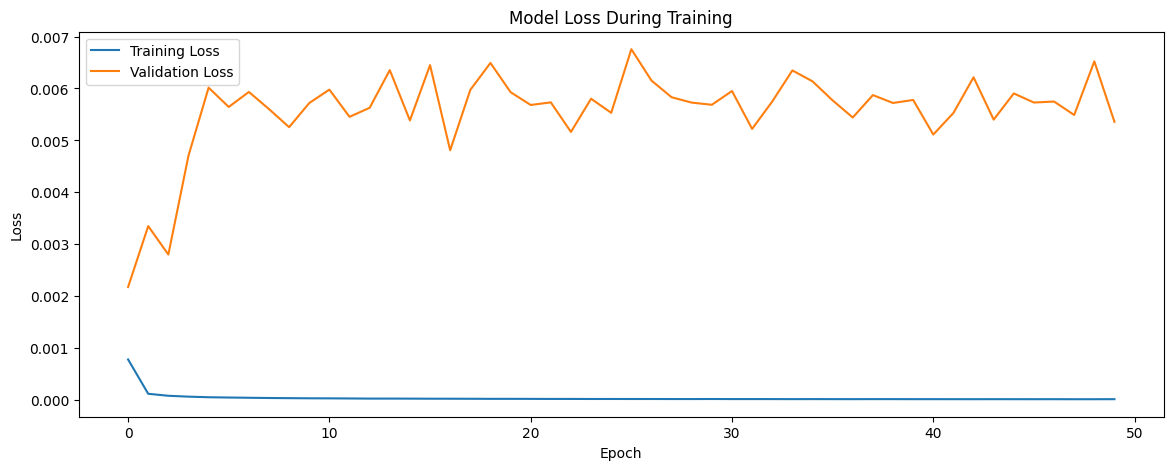

In [18]:
# 14. Plot training and validation loss
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

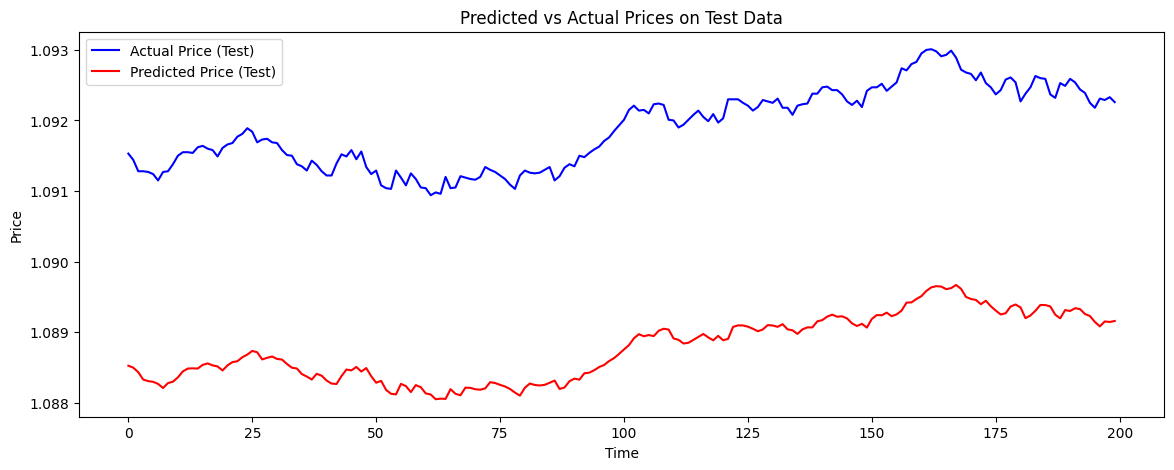

In [20]:
 #15. Plot predictions vs actual prices for test data
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv[:200], color='blue', label='Actual Price (Test)')
plt.plot(test_predict[:200], color='red', label='Predicted Price (Test)')
plt.title('Predicted vs Actual Prices on Test Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reshape y_train and y_test to be 2D for concatenation
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

train_predict_extended = np.concatenate([train_predict, np.zeros((train_predict.shape[0], X.shape[2] - 1))], axis=1)
test_predict_extended = np.concatenate([test_predict, np.zeros((test_predict.shape[0], X.shape[2] - 1))], axis=1)
y_train_extended = np.concatenate([y_train, np.zeros((y_train.shape[0], X.shape[2] - 1))], axis=1)
y_test_extended = np.concatenate([y_test, np.zeros((y_test.shape[0], X.shape[2] - 1))], axis=1)

# Invert predictions and true values back to original scale
train_predict = scaler.inverse_transform(train_predict_extended)[:, 0]  # Only take the 'close' column
y_train = scaler.inverse_transform(y_train_extended)[:, 0]
test_predict = scaler.inverse_transform(test_predict_extended)[:, 0]
y_test = scaler.inverse_transform(y_test_extended)[:, 0]


# Evaluate the model (e.g., RMSE)
train_rmse = np.sqrt(np.mean((train_predict - y_train) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test) ** 2))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')




In [ ]:
# Correctly plot a smaller subset for better visualization
subset_size = 200  # Or any number that fits your desired visualization
plt.figure(figsize=(14, 5))
plt.plot(y_test[:subset_size], color='blue', label='Actual Price (Test)')
plt.plot(test_predict[:subset_size], color='red', label='Predicted Price (Test)')
plt.title('Predicted vs Actual Prices on Test Data (Subset)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Additional plot: Prediction Error on the same subset
plt.figure(figsize=(14, 5))
plt.plot((test_predict[:subset_size] - y_test[:subset_size]), color='purple', label='Prediction Error (Test)')
plt.title('Prediction Error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.show()